In [2]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import transformers

In [3]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
train_valid_data, test_data = datasets.load_dataset(
    "yelp_polarity", split=["train", "test"]
)

Generating test split: 100%|██████████| 38000/38000 [00:00<00:00, 387912.51 examples/s]


In [5]:
train_valid_split = train_valid_data.train_test_split(test_size=0.2)
train_data = train_valid_split["train"]
valid_data = train_valid_split["test"]
train_data, valid_data, test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 448000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 112000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 38000
 }))

In [6]:
transformer_name = "bert-base-uncased"

tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name)

In [7]:
def tokenize_and_numericalize_example(example, tokenizer):
    ids = tokenizer(example["text"], truncation=True)["input_ids"]
    return {"ids": ids}

In [8]:
train_data = train_data.map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)
valid_data = valid_data.map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)
test_data = test_data.map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)

Map: 100%|██████████| 38000/38000 [00:25<00:00, 1487.87 examples/s]


In [9]:
train_data[0]

{'text': "One of our clients brought a beautiful tray of sandwiches for lunch today. I went straight for The California which had avocado, red onions, tomatoes, alfalfa sprouts, banana peppers, Monterey cheese, and mayo on wheat bread. It was wonderful! So I immediately had to do more research about this deli and I am sold! The ingredients are incredibly fresh and I absolutely LOVE how much stuff is in the sandwich! The other three sandwiches look just as delicious (one has turkey and bacon, the second one has pastrami, and the third had pastrami and turkey).  I don't think I could ask of much more out of a sandwich: fresh ingredients, lots of vegetables, and tasty. I will definitely be taking my sandwich-loving fianc\\u00e9 to give it a whirl!",
 'label': 1,
 'ids': [101,
  2028,
  1997,
  2256,
  7846,
  2716,
  1037,
  3376,
  11851,
  1997,
  22094,
  2005,
  6265,
  2651,
  1012,
  1045,
  2253,
  3442,
  2005,
  1996,
  2662,
  2029,
  2018,
  20704,
  24755,
  3527,
  1010,
  24

In [10]:
pad_index = tokenizer.pad_token_id

In [11]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [12]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

In [13]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [14]:
batch_size = 16

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [16]:
class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, ids):
        # ids = [batch size, seq len]
        output = self.transformer(ids, output_attentions=True)
        hidden = output.last_hidden_state
        # hidden = [batch size, seq len, hidden dim]
        attention = output.attentions[-1]
        # attention = [batch size, n heads, seq len, seq len]
        cls_hidden = hidden[:, 0, :]
        prediction = self.fc(torch.tanh(cls_hidden))
        # prediction = [batch size, output dim]
        return prediction

In [17]:
transformer = transformers.AutoModel.from_pretrained(transformer_name)

In [18]:
transformer.config.hidden_size

768

In [19]:
output_dim = len(train_data["label"].unique())
freeze = True

model = Transformer(transformer, output_dim, freeze)

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 1,538 trainable parameters


In [21]:
lr = 1e-5

optimizer = optim.Adam(model.parameters(), lr=lr)

In [22]:
criterion = nn.CrossEntropyLoss()

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [24]:
model = model.to(device)
criterion = criterion.to(device)

In [25]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [26]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [27]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [28]:
n_epochs = 3
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "transformer.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 7000/7000 [16:07<00:00,  7.24it/s]


epoch: 0
train_loss: 0.658, train_acc: 0.606
valid_loss: 0.627, valid_acc: 0.670


evaluating...: 100%|██████████| 7000/7000 [16:07<00:00,  7.24it/s]


epoch: 1
train_loss: 0.626, train_acc: 0.653
valid_loss: 0.597, valid_acc: 0.694


evaluating...: 100%|██████████| 7000/7000 [16:07<00:00,  7.24it/s]


epoch: 2
train_loss: 0.610, train_acc: 0.665
valid_loss: 0.582, valid_acc: 0.700


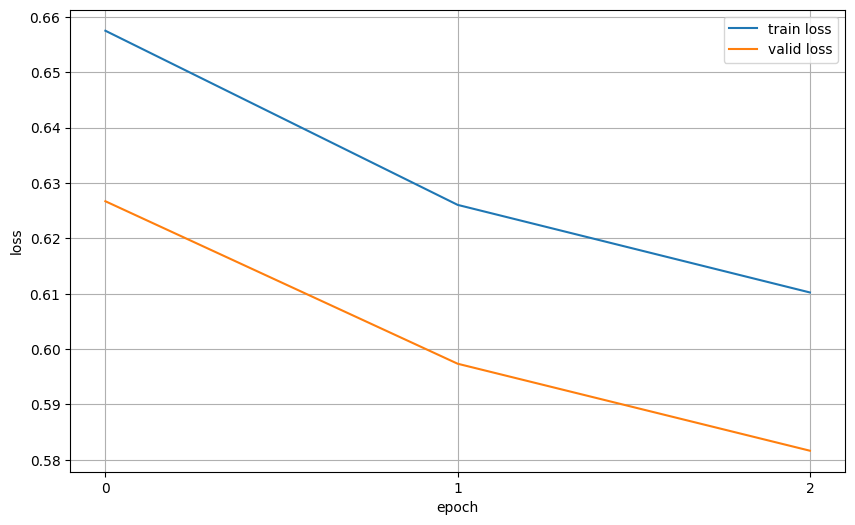

In [29]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

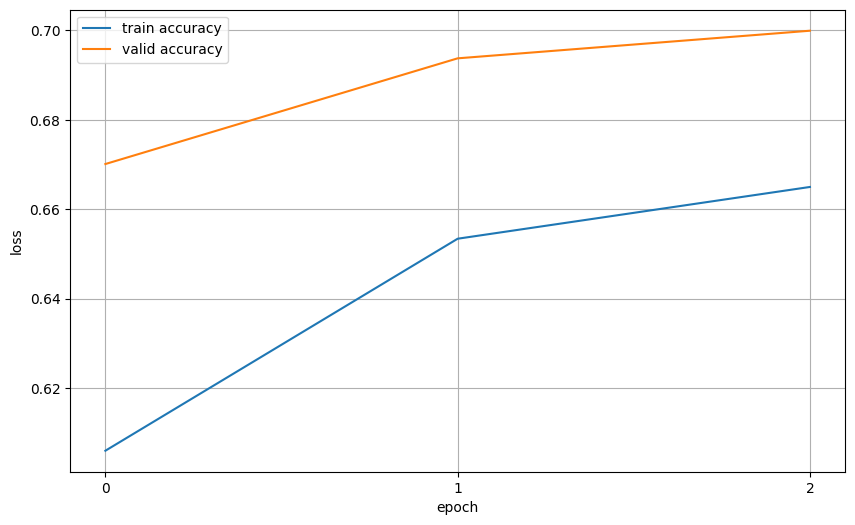

In [30]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [31]:
model.load_state_dict(torch.load("transformer.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|██████████| 2375/2375 [05:23<00:00,  7.33it/s]


In [32]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.579, test_acc: 0.703


In [33]:
def predict_sentiment(text, model, tokenizer, device):
    ids = tokenizer(text)["input_ids"]
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [34]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, device)

(0, 0.7271552085876465)

In [35]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, device)

(1, 0.8644253015518188)

In [36]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, device)

(1, 0.8142952919006348)

In [37]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, device)

(0, 0.7633295655250549)